## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Conclusion](#conclusions)
- [References](#references)


<a id='intro'></a>
### Introduction

In this project, we will be working to understand the results of an A/B test for an e-commerce website. our goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, we will import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.`  <br><br>
a. Read in the dataset and take a look at the top few rows here:

Reading in the dataset and having a look at the top few rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

Finding the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

Getting the number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

Finding the proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

Before moving furthur, we need to be sure that all `new_page`s are assigned to `treatment` and all `old_page`s to `control`

e. The number of times the `new_page` and `treatment` don't line up.

Finding The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group == "treatment" and landing_page == "old_page"').count()[0] + df.query('group == "control" and landing_page == "new_page"').count()[0]

3893

We also need to check if we have any missing values in the dataset.

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No missing values in the dataset, we will need to just deal with our unmatched 3893 rows.

`2.`  <br><br>
a. Create a new dataset that meets the specifications. Store your new dataframe in df2.

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. so, we will be creating a new dataframe that does not contain these rows.

In [8]:
# creating the new df without the unmatched rows.
mask = ((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False
df2 = df.loc[mask == False].copy()
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [9]:
# number of rows in df2
df2.shape[0]

290585

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Now we created our new dataframe and got rid of the unmatched rows. Let's have a look at `df2`.

`3.`  <br><br>
a. How many unique **user_id**s are in **df2**?

Finding how many unique **user_id**s are in **df2**

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

Finding out if we have any duplicates in `user_id`

In [12]:
df2.user_id.duplicated().sum()

1

We have one duplicate user id.

In [13]:
# viewing the duplicate user id
repeat = df2[df2.user_id.duplicated()]
repeat

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# viewing the two user ids
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

information for the repeat **user_id**

In [15]:
print('Information for the repeat user id: \n id is {} \n group is {} \n landing page is {} \n converted state is {}'.format(repeat.iloc[0,0],repeat.iloc[0,2],repeat.iloc[0,3],repeat.iloc[0,4]))

Information for the repeat user id: 
 id is 773192 
 group is treatment 
 landing page is new_page 
 converted state is 0


As we see above they are the same. we need to drop one of them.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

Removing **one** of the rows with a duplicate **user_id** in **df2**.

In [16]:
# removing the duplicate
df2.drop(2893, inplace= True)

In [17]:
# making sure the duplicate was removed
df2.user_id.duplicated().sum()

0

Now after we dealt with the duplicate row, we will now perform some probability calculations with `df2`.

`4.`  <br><br>
a. What is the probability of an individual converting regardless of the page they receive?

Finding out the probability of an individual converting regardless of the page they receive.

In [18]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

Finding out the probability of conversion given that an individual was in the `control` group.

In [19]:
p_control = df2.query('group == "control"')['converted'].mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

Finding out the probability of conversion​ given that an individual was in the `treatment` group.

In [20]:
p_treatment = df2.query('group == "treatment"')['converted'].mean()
p_treatment

0.11880806551510564

In [21]:
# calculating the difference in conversion rate between treatment and control
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

Finding out the probability that an individual received the new page.

In [22]:
df2.query('landing_page == "new_page"').count()[0] / df2.shape[0]

0.50006194422266881

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

The result so far for the probability of conversion from getting the old or new page are almost the same ( 12% and 11.9% respectively). but in order to get a conclusion whether the treatment page leads to more conversions or not, we need to test for significance.

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  
However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?. For now, we will just consider making the decision based on all the data provided.

`1.` What should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

We will now state our null and alternative hypotheses. and will assume a type-I error threshold of 0.05.

$$H_0 : P_{new} - P_{old} \leq 0$$
$$H_1 : P_{new} - P_{old} > 0$$

With $P_{new}$ and $P_{old}$ representing the conversion rate for the new page and old page.

We will assume under the null hypothesis,that $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, we will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

### i. Using Simulation:
we will use a sample size for each page equal to the ones in **ab_data.csv**. and wii perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

`2.` <br><br>
a. What is the **convert rate** for $p_{new}$ under the null? 

Finding the **conversion rate** for $p_{new}$ under the null.

In [23]:
p_new_null = df2.converted.mean()
p_new_null

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

Finding the **conversion rate** for $p_{old}$ under the null.

In [24]:
p_old_null = df2.converted.mean()
p_old_null

0.11959708724499628

c. What is $n_{new}$?

Finding $n_{new}$, which is the number of individuals in the treatment group.

In [25]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

d. What is $n_{old}$?

Finding $n_{old}$, which is the number of individuals in the control group.

In [26]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  and storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice(2, n_new, p=[1-p_new_null, p_new_null])
new_page_converted

array([0, 1, 0, ..., 1, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  and storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice(2, n_old, p=[1-p_old_null, p_old_null])
old_page_converted

array([0, 0, 0, ..., 1, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

Finding $p_{new}$ - $p_{old}$ for our simulated values above.

In [29]:
p_new = new_page_converted.mean()
p_old = old_page_converted.mean()
p_new - p_old

-0.00056645178352232595

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used before, and Storing all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
p_diffs = []
for _ in range(10000):
    p_null = 0.11959708724499628
    n_new, n_old = 145310, 145274
    p_new = np.random.choice(2, n_new, p=[1-p_null, p_null]).mean()
    p_old = np.random.choice(2, n_old, p=[1-p_null, p_null]).mean()
    p_diffs.append(p_new - p_old)

Converting **p_diffs** to a NumPy array.

In [31]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

Plotting a histogram of the **p_diffs**.

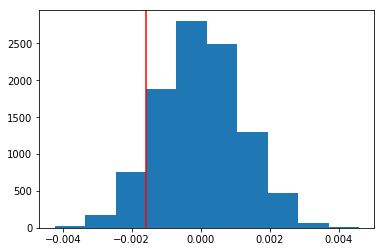

In [32]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

Calculating *p-value*, the proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**.

In [33]:
(p_diffs > obs_diff).mean()

0.90290000000000004

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

What was calculated above is called *p-value*. Basically, we calculated the proportion of values in `p_diffs` that are larger than our observed value `obs_diff`. The result we got (the output of our *p-value*) was **0.902**, which is much beyond our *type-I error threshold of 0.05* - i.e. we have a 90% chance of commiting a type-I error according to our *p-value* output. This results in a failure to reject the null hypothesis and conclude that the new page conversion rate is not better than the old page conversion rate.

### ii. Using a statistical test:

Similar results could be achieved with statistical tests. we will use `statsmodels`'s `.proportions_ztest` to calculate our *p-value* .

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

Calculating the number of conversions for each page, as well as the number of individuals who received each page. With `n_old` and `n_new` referring to the the number of rows associated with the old page and new pages and `convert_old` and `convert_new` referring to the number of conversions for old page and new page, respectively.

In [53]:
# importing statsmodels library
import statsmodels.api as sm

In [35]:
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

using `stats.proportions_ztest` to compute our test statistic and p-value.

In [36]:
stat, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], value = 0, alternative= 'larger' )
stat, pval

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The computed *p-value* from the above statistical test confirm and agree with the one computed from our simulation. meaning that there is no statistically significant difference between the conversion rates of both pages.

<a id='regression'></a>
### Part III - A regression approach

In this part, we will try to achieve the results that was obtained in the A/B test in Part II above by performing regression. 
And since each row is either a conversion or no conversion, we will be performing a **Logistic Regression** in this case.

`1.` <br><br>
a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case? <br><br>
In this case we will be using **Logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

We will use `statsmodels` to fit our logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.

First need to create a column for the intercept in df2.

In [37]:
# creating the intercept column
df2['intercept'] = 1

Creating a dummy variable column for which page each user received. and we will name it `ab_page` with 1 standing for `new_page` and 0 for `old_page`.

In [38]:
# creating the dummy variable column
dummies = pd.get_dummies(df2['group'])
df2['ab_page'] = dummies['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

Instantiating our regression model on `intercept` and `ab_page` with `converted` being our response variable. 

In [39]:
mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

Fitting our regression model.

In [40]:
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

To generate a summary we used `.summary2()` in order to get rid of the `module 'scipy.stats' has no attribute 'chisqprob'` bug.
(check references)

In [41]:
print(res.summary2())

                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-26 21:06 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074



e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

From the provided summary we can see that the *p-value* for the `ab_page` is **0.1899**, which is still high enough resulting in a failure to reject the null hypothesis but is different from what we calculated in the A/B test.

 The null and alternative hypotheses associated with our regression model are:
 $$H_0 : P_{new} - P_{old} = 0$$
 $$H_1 : P_{new} - P_{old} \neq 0$$
 This way of presenting the null and alternative hypotheses results in a different output of *p-value* as the area under curve of the sampling distribution under the null that corresponds to *p-value* is different.

### Adding other factors:

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Considering adding othe factors to our regression model could help in obtaining better prediction results.but it also has its possible disadvantages.

**disadvantages to adding additional terms into our regression model include:**
1. Non-linearity of the response-predictor relationships
2. Correlated errors
3. Non-constant Variance 
4. Outliers
5. Multicollinearity 

g. Read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together our datasets on the appropriate rows. 

In [42]:
# Loading countries dataset
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
# getting the unique values in country column
countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

We will now use pandas `join()` to join our two datasets and saving the result in a new dataframe which we will call `df3`.

In [44]:
# joining the two datasets.
df3 = df2.join(countries.set_index('user_id'), on='user_id', how = 'left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [45]:
# checking the number of rows in the new dataframe
df3.shape[0]

290584

In [46]:
# checking for missing values in the new dataframe
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
dtypes: int64(3), object(4), uint8(1)
memory usage: 18.0+ MB


We will now create the dummy variable column for `country`

In [47]:
# creating the dummy variable
df3[['ca','uk','us']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,ca,uk,us
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


Instantiating then fitting our regression model on `intercept`, `ab_page`, `uk`, and `us`. with `converted` being our response variable.

In [48]:
mod = sm.Logit(df3['converted'],df3[['intercept','ab_page','uk','us']])
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


Generating the summary for our model.

In [49]:
print(res.summary2())

                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-26 21:06 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
uk             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
us             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934



The *p-value* for all factors are still high enough resulting in failure to reject the null : **0.0745** and **0.1295** for `uk` and `us` respectively, `ab_page` got a *p-value* of **0.1912**, almost the same as the result obtained from the analysis of `ab_page` alone (provided in the previous test), so we can say that the inclusion of countries does not appear to have an impact on conversion.

### Modeling interactions:

We will now look at an interaction between page and country to see if there is a significant effects on conversion.  

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model. Provide the summary results, and your conclusions based on the results.

In [50]:
# Creating the columns for interactions
df3['uk_ab'] = df3['ab_page'] * df3['uk']
df3['us_ab'] = df3['ab_page'] * df3['us']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,ca,uk,us,uk_ab,us_ab
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


Instantiating then fitting our regression model on `intercept`, `ab_page`, `uk`, `us`, `uk_ab`, and `us_ab`. with `converted` being our response variable.

In [51]:
mod_interact = sm.Logit(df3['converted'],df3[['intercept','ab_page','uk','us','uk_ab','us_ab']])
res_interact = mod_interact.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


Generating the summary for our model.

In [52]:
print(res_interact.summary2())

                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-10-26 21:06 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
uk             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
us             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
uk_ab         

From viewing the above summary we can see that the *p-values* for our factors are all too high to be statistically significant.
`ab_page` with a *p-value* of **0.1947**, and each of its interactions has a *p-value* of **0.1681** and **0.3833** for `uk_ab` and `us_ab` respectively, showing interaction between page and country has no significant effects on conversion.

<a id='conclusions'></a>
## Final Conclusion

From the results of the performed tests above we can conclude that we have no evidence of the new page conversion rate being higher than the old page conversion rate, and so we fail to reject the null hypothesis. and given that, we recommend that the company keep the old page.

<a id='references'></a>
## References

1. [Documentation for statsmodels proportions_ztest()](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html)
2. [Stackoverflow post on the summary() error](https://stackoverflow.com/questions/49814258/statsmodel-attributeerror-module-scipy-stats-has-no-attribute-chisqprob)
3. [Documentation for pandas join()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html)